<a href="https://colab.research.google.com/github/ErikMayerPSU/AuroraNSL_2024/blob/main/Code/binary_classification_development/binary_classification_2025_0508_1000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Classification

Source: https://github.com/logictensornetworks/logictensornetworks/blob/master/examples/binary_classification/binary_classification.ipynb

Modified by Erik Mayer:
+ 6/17/2024: To work on Google Colab, added !pip install...
+ 6/20/2024: See below (undone on 6/23/2024?)
+ 6/21/2024: Specifying array values
+ 6/23/2024: Using data from eflux file on GitHub.
++ 7:52 am: Switched to eflux file for 3/18/2024 2:00 UT with more interesting data, but training appears to have issues. Taking long time and sat level is nan. Number of data points too large?
+ 6/24/2024: Experimenting with training
++ 7:15 am: Tried shuffling dataset, but seemed to only get 100 data points. Pulls 100 data points and then shuffles? See below.
++ 7:45 pm: Trying to shuffle numpy array array_eflux
+ 6/27/2024: Branching from binary_classification_2024_0624_p0743.ipynb
++ Attempting to choose a different set of training data every epoch (see comment in code below)


This is a basic example in which we learn to ground unary predicate $A$ that is defined in the space of $[0,1]^2$.

We define the predicate $A$ to apply to points that are close to the middle point $c=(.5,.5)$.In order to get training data, we randomly sample data from the domain. We split the sample data into two separate sets based on their euclidian distance to $c$. We then define two facts for the predicate $A$. For all points the predicate should apply to, we provide them as positive examples and vice versa for all points that the predicate does not apply to.

To add a local copy of the LogicTensorNetworks repository into your Colab environment, use the following command:

In [17]:
!pip install git+https://github.com/logictensornetworks/logictensornetworks

  Cloning https://github.com/logictensornetworks/logictensornetworks to /tmp/pip-req-build-xit289wk
  Running command git clone --filter=blob:none --quiet https://github.com/logictensornetworks/logictensornetworks /tmp/pip-req-build-xit289wk
  Resolved https://github.com/logictensornetworks/logictensornetworks to commit f3027f32fb45ce880fd5536f9dc0592da01fe5c9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [18]:
!pip install aacgmv2

In [19]:
import logging; logging.basicConfig(level=logging.INFO)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import ltn

import aacgmv2 as aacgmv2

plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1

Sample random data from $[0,1]^2$. Our groundtruth positive training data for $A$ is close to the center (.5,.5). All other data is considered as negative examples.

# E.M. modifications 6/23/2024

Read data from IMF file on GitHub (see File_reading_2024_0623_a0607.ipynb)

In [20]:
import pandas as pd

import numpy as np

In [21]:
# input data
# 6/23/2024 Not currently using this data in this notebook

df_IMF = pd.read_csv(r"https://raw.githubusercontent.com/ErikMayerPSU/AuroraNSL_2024/main/data/St%20patrick's%20day%202015/20150317_IMF.txt", header=None, nrows=1, delim_whitespace=True, on_bad_lines='skip')

# Define new headers
IMF_headers = ["Year", "Month", "Day", "Hour", "Min", "Sec", "Msec", "Bx[nT]", "By[nT]", "Bz[nT]", "Vx[km/s]", "Vy[km/s]", "Vz[km/s]", "N[cm^(-3)]", "T[Kelvin]"]

# Set the column headers
df_IMF.columns = IMF_headers

df_IMF

<ipython-input-21-1975fa5d2963>:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_IMF = pd.read_csv(r"https://raw.githubusercontent.com/ErikMayerPSU/AuroraNSL_2024/main/data/St%20patrick's%20day%202015/20150317_IMF.txt", header=None, nrows=1, delim_whitespace=True, on_bad_lines='skip')


,Year,Month,Day,Hour,Min,Sec,Msec,Bx[nT],By[nT],Bz[nT],Vx[km/s],Vy[km/s],Vz[km/s],N[cm^(-3)],T[Kelvin]
0,2015,3,17,0,0,0,0,-4.41,-0.319,6.176,-422.716,13.163,-5.809,12.914,43258.2


In [22]:
# output data

df_eflux = pd.read_csv(r"https://raw.githubusercontent.com/ErikMayerPSU/AuroraNSL_2024/main/data/St%20patrick's%20day%202015/Eflux/20150318_0200UT_Eflux_e%2Call.txt", header=None, skiprows=1, nrows=7680, delim_whitespace=True, on_bad_lines='skip')

# Define new headers
eflux_headers = ["MLT", "ML", "[mW m^-2]"]

# Set the column headers
df_eflux.columns = eflux_headers

df_eflux

<ipython-input-22-95fb87b460aa>:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_eflux = pd.read_csv(r"https://raw.githubusercontent.com/ErikMayerPSU/AuroraNSL_2024/main/data/St%20patrick's%20day%202015/Eflux/20150318_0200UT_Eflux_e%2Call.txt", header=None, skiprows=1, nrows=7680, delim_whitespace=True, on_bad_lines='skip')


,MLT,ML,[mW m^-2]
0,0.00,50.0,0.009205
1,0.00,50.5,0.009303
2,0.00,51.0,0.005775
3,0.00,51.5,0.020590
4,0.00,52.0,0.000387
...,...,...,...
7675,23.75,87.5,0.023140
7676,23.75,88.0,0.022190
7677,23.75,88.5,0.023080
7678,23.75,89.0,0.016270


# Added code below to read the Aurorasaurus data and add to the df for use during training.

Aurorasaurus data not actually used yet.

In [23]:
df_aurorasaurus = pd.read_csv(r"https://raw.githubusercontent.com/ErikMayerPSU/AuroraNSL_2024/refs/heads/main/data/20150318_0200UT_web_observations_and_tweets.txt", header=None, nrows=23, sep='\s+', on_bad_lines='skip')

# Define new headers
eflux_headers1 = ["see_aurora","date" ,"time", "st_y", "st_x"]

# Set the column headers
df_aurorasaurus.columns = eflux_headers1

df_aurorasaurus

,see_aurora,date,time,st_y,st_x
0,1,2015-03-18,02:00:00+00,66.064519,-18.660158
1,0,2015-03-18,02:00:00+00,39.053329,-75.511607
2,1,2015-03-18,02:00:00+00,54.548501,-3.591408
3,0,2015-03-18,02:00:00+00,39.235292,-75.722088
4,1,2015-03-18,02:00:00+00,43.141995,-77.626895
5,0,2015-03-18,02:00:00+00,39.933899,-74.939244
6,1,2015-03-18,02:00:00+00,40.035265,-78.032827
7,0,2015-03-18,02:00:00+00,38.953415,-75.824369
8,1,2015-03-18,02:00:00+00,54.503138,-8.201311
9,1,2015-03-18,02:00:00+00,43.074327,-77.082157


In [24]:
# Converting column data from CSV to lists
xcoords = df_aurorasaurus['st_x'].tolist()
ycoords = df_aurorasaurus['st_y'].tolist()
date_time = pd.to_datetime(df_aurorasaurus['time'])  #Store date and time in a variable

# Function to convert coordinates (Geo to AACGM)
def convert_to_aacgm(geo_lat, geo_lon, altitude, dtime):
    aacgm_lat, aacgm_lon, aacgm_r = aacgmv2.wrapper.convert_latlon(
        geo_lat, geo_lon, altitude, dtime, method_code='G2A'
    )
    return aacgm_lat, aacgm_lon, aacgm_r

# Lists to store results
aacgm_latitudes = []
aacgm_longitudes = []
aacgm_radii = []
mlt_values = []

# Convert each coordinate with corresponding time
for lat, lon, time in zip(ycoords, xcoords, date_time):
    out_lat, out_lon, out_r = convert_to_aacgm(lat, lon, 0, time)  #Assuming altitude = 0
    aacgm_latitudes.append(out_lat)
    aacgm_longitudes.append(out_lon)
    aacgm_radii.append(out_r)

    # Convert AACGM longitude to MLT
    mlt = aacgmv2.convert_mlt(out_lon, time, m2a=False)[0]
    mlt_values.append(mlt)

temp = pd.DataFrame({
    'ML': aacgm_latitudes,
    'MLT': mlt_values
}, index=df_aurorasaurus.index)  # Align index with original DataFrame

# Concatenate the original and new DataFrames horizontally
df_aurorasaurus = pd.concat([df_aurorasaurus, temp], axis=1)

#Round the values of ML to the nearest 0.5 value so they fit in the established bins
df_aurorasaurus['ML'] = (df_aurorasaurus['ML'] * 2).round() / 2

#Round the values of MLT to the nearest 0.5 value so they fit in the established bins
df_aurorasaurus['MLT'] = (df_aurorasaurus['MLT'] * 4).round() / 4

df_aurorasaurus



<ipython-input-24-444f247a76f9>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date_time = pd.to_datetime(df_aurorasaurus['time'])  #Store date and time in a variable


,see_aurora,date,time,st_y,st_x,ML,MLT
0,1,2015-03-18,02:00:00+00,66.064519,-18.660158,65.5,1.75
1,0,2015-03-18,02:00:00+00,39.053329,-75.511607,47.0,21.50
2,1,2015-03-18,02:00:00+00,54.548501,-3.591408,51.0,2.25
3,0,2015-03-18,02:00:00+00,39.235292,-75.722088,47.5,21.50
4,1,2015-03-18,02:00:00+00,43.141995,-77.626895,51.5,21.25
5,0,2015-03-18,02:00:00+00,39.933899,-74.939244,48.0,21.50
6,1,2015-03-18,02:00:00+00,40.035265,-78.032827,48.5,21.25
7,0,2015-03-18,02:00:00+00,38.953415,-75.824369,47.0,21.50
8,1,2015-03-18,02:00:00+00,54.503138,-8.201311,51.0,2.00
9,1,2015-03-18,02:00:00+00,43.074327,-77.082157,51.5,21.25


In [25]:
df_eflux['see_aurora'] = np.nan

for i, row in df_aurorasaurus.iterrows():
    mlt = row['MLT']
    ml = row['ML']
    df_eflux.loc[(df_eflux['MLT'] == mlt) & (df_eflux['ML'] == ml), 'see_aurora'] = df_aurorasaurus.loc[i, 'see_aurora']

df_eflux


,MLT,ML,[mW m^-2],see_aurora
0,0.00,50.0,0.009205,NaN
1,0.00,50.5,0.009303,NaN
2,0.00,51.0,0.005775,NaN
3,0.00,51.5,0.020590,NaN
4,0.00,52.0,0.000387,NaN
...,...,...,...,...
7675,23.75,87.5,0.023140,NaN
7676,23.75,88.0,0.022190,NaN
7677,23.75,88.5,0.023080,NaN
7678,23.75,89.0,0.016270,NaN


In [26]:
array_eflux = df_eflux.to_numpy()
array_eflux

array([[0.000e+00, 5.000e+01, 9.205e-03,       nan],
       [0.000e+00, 5.050e+01, 9.303e-03,       nan],
       [0.000e+00, 5.100e+01, 5.775e-03,       nan],
       ...,
       [2.375e+01, 8.850e+01, 2.308e-02,       nan],
       [2.375e+01, 8.900e+01, 1.627e-02,       nan],
       [2.375e+01, 8.950e+01, 2.794e-02,       nan]])

In [27]:
# 6/24/2024 7:45 pm Trying to shuffle numpy array array_eflux
np.random.shuffle(array_eflux)
array_eflux

array([[1.925e+01, 5.400e+01, 2.294e-02,       nan],
       [6.500e+00, 7.650e+01, 4.615e-01,       nan],
       [2.350e+01, 6.500e+01, 5.603e+00,       nan],
       ...,
       [5.000e-01, 5.200e+01, 6.168e-03,       nan],
       [2.125e+01, 6.100e+01, 2.187e+00,       nan],
       [1.950e+01, 5.000e+01, 1.676e-02,       nan]])

In [28]:
array_eflux_mag_coordinates = array_eflux[0:7680,0:2]
array_eflux_mag_coordinates
data = array_eflux_mag_coordinates
data

array([[19.25, 54.  ],
       [ 6.5 , 76.5 ],
       [23.5 , 65.  ],
       ...,
       [ 0.5 , 52.  ],
       [21.25, 61.  ],
       [19.5 , 50.  ]])

In [29]:
array_eflux_flux = array_eflux[0:7680,2:3]
print(array_eflux_flux)
# Flatten to 1-D array
array_eflux_flux_flatten = array_eflux_flux.flatten(order = 'C')
print(array_eflux_flux_flatten)


[[0.02294 ]
 [0.4615  ]
 [5.603   ]
 ...
 [0.006168]
 [2.187   ]
 [0.01676 ]]
[0.02294  0.4615   5.603    ... 0.006168 2.187    0.01676 ]


In [30]:
# Using aurora visibility threshold = 1
labels = array_eflux_flux_flatten > 1.0
# labels_b = np.sum(np.square(data_b-[.5,.5]),axis=1)<.16
print(labels)

[False False  True ... False  True False]


Data for A:
[[19.25 54.  ]
 [ 6.5  76.5 ]
 [23.5  65.  ]
 ...
 [ 0.5  52.  ]
 [21.25 61.  ]
 [19.5  50.  ]]
[False False  True ... False  True False]


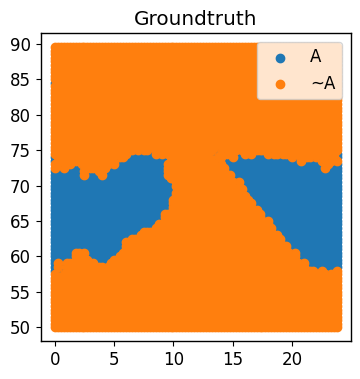

Data for B:
[[0.55 0.55]
 [0.65 0.65]
 [0.45 0.45]
 [0.35 0.35]
 [0.25 0.25]
 [0.15 0.15]]
[ True  True  True  True  True False]


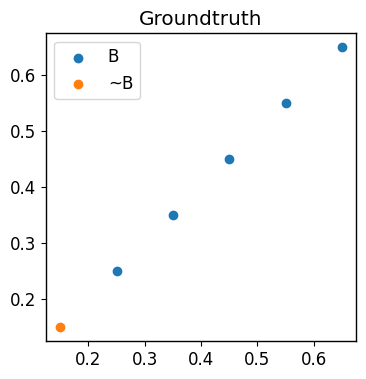

Plotting A and B on same graph


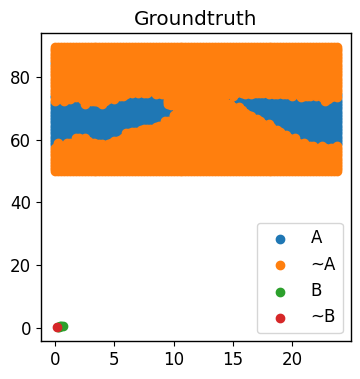

Concatendated A and B data (6/23/2024: just using A):
[[19.25 54.  ]
 [ 6.5  76.5 ]
 [23.5  65.  ]
 ...
 [ 0.5  52.  ]
 [21.25 61.  ]
 [19.5  50.  ]]
[False False  True ... False  True False]
<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 2), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.bool, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 2), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.bool, name=None))>


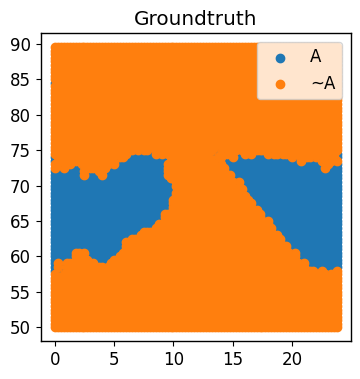

In [31]:
batch_size= 64 # previously 64
nr_samples = 7680 # previously 100

# See https://www.tensorflow.org/tutorials/load_data/numpy
SHUFFLE_BUFFER_SIZE = 7680

half_nr_samples = 6 # no longer used? Only used when randomizing test data?
nr_samples_train = 100 # 5760 # previously 50 E.M. - Why no nr_samples_test ?
# data = np.random.uniform([0,0],[1,1],(half_nr_samples,2))
# data from eflux file (see above): data    = np.array([[0.5,0.5],[0.6,0.6],[0.4,0.4],[0.3,0.3],[0.2,0.2],[0.1,0.1]],  dtype=float)

# Data for A from eflux file on GitHub
print("Data for A:")
print(data) # Added E.M.
# E.M. Changed from [.5,.5] to [.5,1] below:
# labels from eflux file (see above): labels = np.sum(np.square(data-[.5,.5]),axis=1)<.09
# This doesn't work. Error: label needs to be integer or boolean: labels = np.sum(np.square(data-[.5,.5]),axis=1)
print(labels) # Added E.M.

plt.figure(figsize=(4,4))
plt.scatter(data[labels][:,0],data[labels][:,1],label='A')
plt.scatter(data[np.logical_not(labels)][:,0],data[np.logical_not(labels)][:,1],label='~A')

#plt.scatter(data_b[labels_b][:,0],data_b[labels_b][:,1],label='B')
#plt.scatter(data_b[np.logical_not(labels_b)][:,0],data_b[np.logical_not(labels_b)][:,1],label='~B')

plt.title("Groundtruth")
plt.legend()
plt.show()

# Test points for B dataset
print("Data for B:")
# data_b = np.random.uniform([0,0],[1,1],(half_nr_samples,2))
data_b    = np.array([[0.55,0.55],[0.65,0.65],[0.45,0.45],[0.35,0.35],[0.25,0.25],[0.15,0.15]],  dtype=float)
print(data_b) # Added E.M.
# E.M. Changed from [.5,.5] to [.5,1] below:
labels_b = np.sum(np.square(data_b-[.5,.5]),axis=1)<.16
# This doesn't work. Error: label needs to be integer or boolean: labels = np.sum(np.square(data-[.5,.5]),axis=1)
print(labels_b) # Added E.M.

plt.figure(figsize=(4,4))
#plt.scatter(data[labels][:,0],data[labels][:,1],label='A')
#plt.scatter(data[np.logical_not(labels)][:,0],data[np.logical_not(labels)][:,1],label='~A')

plt.scatter(data_b[labels_b][:,0],data_b[labels_b][:,1],label='B')
plt.scatter(data_b[np.logical_not(labels_b)][:,0],data_b[np.logical_not(labels_b)][:,1],label='~B')

plt.title("Groundtruth")
plt.legend()
plt.show()

print("Plotting A and B on same graph")

plt.figure(figsize=(4,4))
plt.scatter(data[labels][:,0],data[labels][:,1],label='A')
plt.scatter(data[np.logical_not(labels)][:,0],data[np.logical_not(labels)][:,1],label='~A')

plt.scatter(data_b[labels_b][:,0],data_b[labels_b][:,1],label='B')
plt.scatter(data_b[np.logical_not(labels_b)][:,0],data_b[np.logical_not(labels_b)][:,1],label='~B')

plt.title("Groundtruth")
plt.legend()
plt.show()

print("Concatendated A and B data (6/23/2024: just using A):")
#data = np.concatenate((data, data_b))
#labels = np.concatenate((labels, labels_b))

print(data)
print(labels)

# Below comment doesn't seem to match program
# 400 examples for training; 100 examples for training
# See https://www.tensorflow.org/tutorials/load_data/numpy
# See https://www.tensorflow.org/guide/data

# Original line:
# ds_train = tf.data.Dataset\
#        .from_tensor_slices((data[:nr_samples_train],labels[:nr_samples_train]))\
#        .batch(batch_size)

# 6/24/2024: Experimenting with training
#     7:15 am: Tried shuffling dataset, but seemed to only get 100 data points. Pulls 100 data points and then shuffles? See below.
# 6/27/2024: Change order of methods .shuffle and .batch.  Missing )?
ds_train = tf.data.Dataset\
        .from_tensor_slices((data[:nr_samples_train],labels[:nr_samples_train]))\
        .batch(batch_size).shuffle(SHUFFLE_BUFFER_SIZE)
#       .shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)


print (ds_train) # Added E. M
ds_test = tf.data.Dataset\
        .from_tensor_slices((data[nr_samples_train:],labels[nr_samples_train:]))\
        .batch(batch_size)
print (ds_test) # Added E. M
plt.figure(figsize=(4,4))
plt.scatter(data[labels][:,0],data[labels][:,1],label='A')
plt.scatter(data[np.logical_not(labels)][:,0],data[np.logical_not(labels)][:,1],label='~A')

#plt.scatter(data_b[labels_b][:,0],data_b[labels_b][:,1],label='B')
#plt.scatter(data_b[np.logical_not(labels_b)][:,0],data_b[np.logical_not(labels_b)][:,1],label='~B')



plt.title("Groundtruth")
plt.legend()
plt.show()


Define the predicate $A$. $A$ has arity 1 (single argument). The dimension of the argument is 2 (since the domain is $[0,1]^2$).

In [32]:
#A = ltn.Predicate.MLP([(2,)],hidden_layer_sizes=(16,16))
#A = ltn.Predicate.MLP([(2,)],hidden_layer_sizes=(32,24,16))
A = ltn.Predicate.MLP([(2,)],hidden_layer_sizes=(128,128,64,48))
#A = ltn.Predicate.MLP([2],hidden_layer_sizes=(2,))

Import some operators to write the axioms.

In [33]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(p=2),semantics="exists")

Now we add some facts to the knowledgebase. We express that for all points in $\mathrm{data\_A}$, $A$ should be true. For all points in $\mathrm{data\_not\_A}$, $A$ is not true.

In [34]:
formula_aggregator = ltn.Wrapper_Formula_Aggregator(ltn.fuzzy_ops.Aggreg_pMeanError(p=2))

@tf.function
def axioms(data, labels):
    x_A = ltn.Variable("x_A",data[labels])
    x_not_A = ltn.Variable("x_not_A",data[tf.logical_not(labels)])
   # x_B = ltn.Variable("x_B",data_b[labels_b])
   # x_not_B = ltn.Variable("x_not_B",data_b[tf.logical_not(labels_b)])
    axioms = [
        Forall(x_A, A(x_A)),
        Forall(x_not_A, Not(A(x_not_A)))
    ]
    sat_level = formula_aggregator(axioms).tensor
    return sat_level

Initialize all layers and the static graph.

In [35]:
for _data, _labels in ds_test:
    print("Initial sat level %.5f"%axioms(_data, _labels))
    break


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 2))
  warnings.warn(msg)


Initial sat level 0.33037


Train on the knowledgebase.

In [36]:
mean_metrics = tf.keras.metrics.Mean()

trainable_variables = A.trainable_variables
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

for epoch in range(2000):
  # 6/27/2024: Added following lines to try and use different training set each epoch
    np.random.shuffle(array_eflux)
    #print(array_eflux)
    array_eflux_mag_coordinates = array_eflux[0:7680,0:2]
    data = array_eflux_mag_coordinates
    #print(data)
    array_eflux_flux = array_eflux[0:7680,2:3]
    #print(array_eflux_flux)
    # Flatten to 1-D array
    array_eflux_flux_flatten = array_eflux_flux.flatten(order = 'C')
    #print(array_eflux_flux_flatten)
    labels = array_eflux_flux_flatten > 1.0
    # labels_b = np.sum(np.square(data_b-[.5,.5]),axis=1)<.16
    #print(labels)
    ds_train = tf.data.Dataset\
        .from_tensor_slices((data[:nr_samples_train],labels[:nr_samples_train]))\
        .batch(batch_size).shuffle(SHUFFLE_BUFFER_SIZE)

    for _data, _labels in ds_train:
        with tf.GradientTape() as tape:
            loss = 1. - axioms(_data, _labels)
        grads = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(grads, trainable_variables))
    if epoch%100 == 0:
        mean_metrics.reset_state()
        for _data, _labels in ds_test:
            mean_metrics(axioms(_data, _labels))
        print("Epoch %d: Sat Level %.3f"%(epoch, mean_metrics.result() ))
mean_metrics.reset_state()
for _data, _labels in ds_test:
    mean_metrics(axioms(_data, _labels))
print("Training finished at Epoch %d with Sat Level %.3f"%(epoch, mean_metrics.result() ))

Epoch 0: Sat Level 0.293
Epoch 100: Sat Level 0.293
Epoch 200: Sat Level 0.293
Epoch 300: Sat Level 0.293
Epoch 400: Sat Level 0.293
Epoch 500: Sat Level 0.293
Epoch 600: Sat Level 0.293
Epoch 700: Sat Level 0.293
Epoch 800: Sat Level 0.293
Epoch 900: Sat Level 0.293
Epoch 1000: Sat Level 0.293
Epoch 1100: Sat Level 0.293
Epoch 1200: Sat Level 0.293
Epoch 1300: Sat Level 0.293
Epoch 1400: Sat Level 0.293
Epoch 1500: Sat Level 0.293
Epoch 1600: Sat Level 0.293
Epoch 1700: Sat Level 0.293
Epoch 1800: Sat Level 0.293
Epoch 1900: Sat Level 0.293
Training finished at Epoch 1999 with Sat Level 0.293


The following queries the database on training data and test data. Vizualisation show the extent of generalization.

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(100, 2))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(7580, 2))
  warnings.warn(msg)


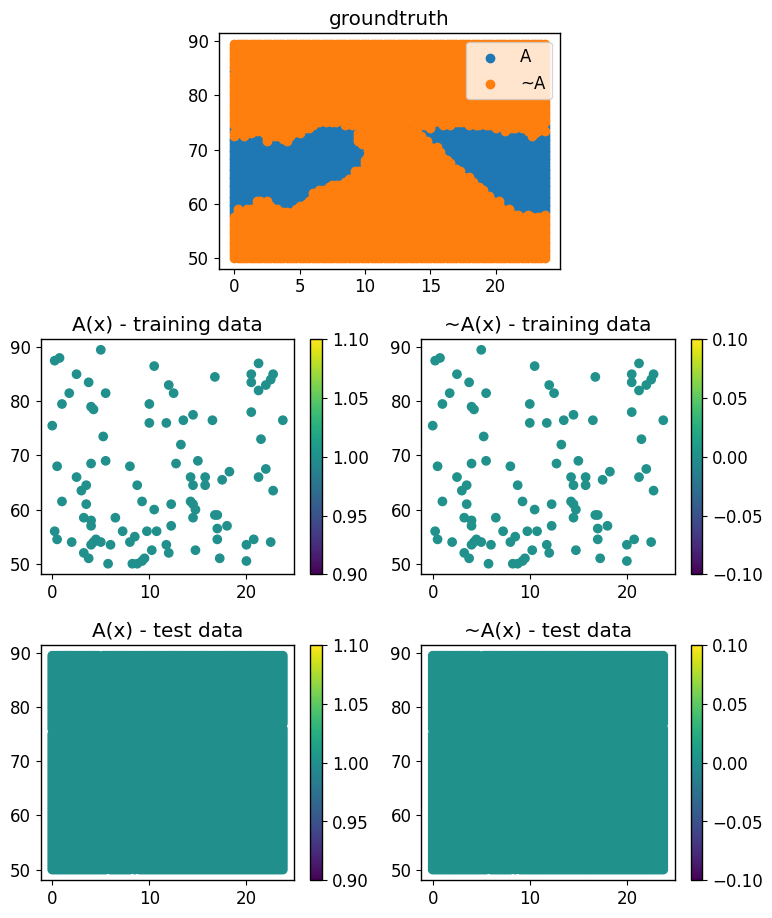

In [37]:
fig = plt.figure(figsize=(9, 11))

plt.subplots_adjust(wspace=0.2,hspace=0.3)
ax = plt.subplot2grid((3,8),(0,2),colspan=4)
ax.set_title("groundtruth")
ax.scatter(data[labels][:,0],data[labels][:,1],label='A')
ax.scatter(data[np.logical_not(labels)][:,0],data[np.logical_not(labels)][:,1],label='~A')
ax.legend()

# Training data
x = ltn.Variable("x",data[:nr_samples_train])
fig.add_subplot(3, 2, 3)
result=A(x)
plt.title("A(x) - training data")
plt.scatter(data[:nr_samples_train,0],data[:nr_samples_train,1],c=result.tensor.numpy().squeeze())
plt.colorbar()

fig.add_subplot(3, 2, 4)
result=Not(A(x))
plt.title("~A(x) - training data")
plt.scatter(data[:nr_samples_train,0],data[:nr_samples_train,1],c=result.tensor.numpy().squeeze())
plt.colorbar()

# Test data
x = ltn.Variable("x",data[nr_samples_train:])
fig.add_subplot(3, 2, 5)

result=A(x)
plt.title("A(x) - test data")
plt.scatter(data[nr_samples_train:,0],data[nr_samples_train:,1],c=result.tensor.numpy().squeeze())
plt.colorbar()

fig.add_subplot(3, 2, 6)
result=Not(A(x))
plt.title("~A(x) - test data")
plt.scatter(data[nr_samples_train:,0],data[nr_samples_train:,1],c=result.tensor.numpy().squeeze())
plt.colorbar()
plt.savefig("ex_binary_testing.pdf")
plt.show()

In [38]:
# Get A(x) predictions
x2 = ltn.Variable("x",data)
predictions = A(x2).tensor.numpy().squeeze()  # Convert LTN result to numpy array

# Add predictions to DataFrame
df_eflux['A(x)'] = predictions
df_eflux

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(7680, 2))
  warnings.warn(msg)


,MLT,ML,[mW m^-2],see_aurora,A(x)
0,0.00,50.0,0.009205,NaN,1.0
1,0.00,50.5,0.009303,NaN,1.0
2,0.00,51.0,0.005775,NaN,1.0
3,0.00,51.5,0.020590,NaN,1.0
4,0.00,52.0,0.000387,NaN,1.0
...,...,...,...,...,...
7675,23.75,87.5,0.023140,NaN,1.0
7676,23.75,88.0,0.022190,NaN,1.0
7677,23.75,88.5,0.023080,NaN,1.0
7678,23.75,89.0,0.016270,NaN,1.0


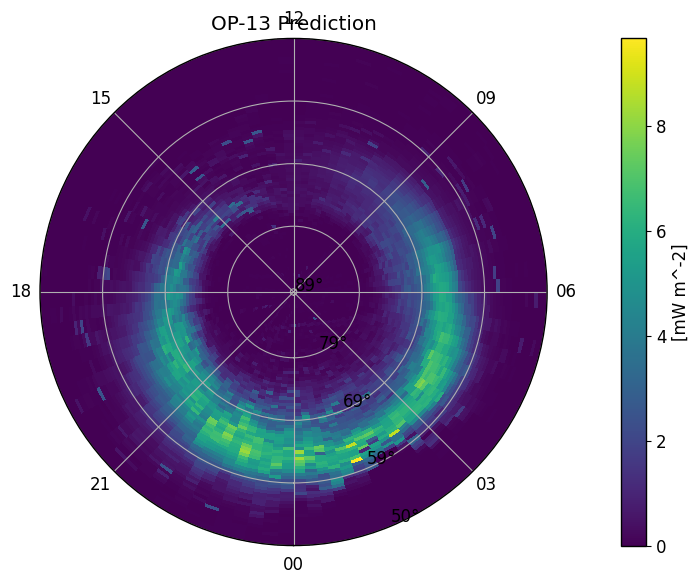

In [39]:
# Reshape into a grid (MLT=rows, ML=columns)
grid = df_eflux.pivot(index='MLT', columns='ML', values='[mW m^-2]')

# Convert MLT to radians
theta = np.deg2rad(grid.index * 15)  # 15° per hour

#Invert ML since the plot was backward
ml = grid.columns.values
ml_inverted = ml.max() - ml

# Extend edges for pcolormesh
theta_edges = np.append(theta, theta[0] + 2*np.pi)  # Close the loop (24h)
ml_edges = np.append(ml_inverted, ml_inverted[-1] + np.diff(ml_inverted)[0])  # Extend edges


# Plot
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': 'polar'})
pc = ax.pcolormesh(
    theta_edges,
    ml_edges,
    grid.T,  # Transpose to match (ML, MLT)
    cmap='viridis',
    shading='auto'
)

ax.set_theta_zero_location('S')  # 0° at bottom
ax.set_theta_direction(1)       # Set correct direction for MLT

# Label MLT ticks
ax.set_xticks(np.linspace(0, 2*np.pi, 8, endpoint=False))
ax.set_xticklabels(['00', '03', '06', '09', '12', '15', '18', '21'])

# Label ML ticks
r_ticks = np.linspace(ml.min(), ml.max(), 5)
ax.set_yticks(ml.max() - r_ticks)
ax.set_yticklabels([f'{int(x)}°' for x in r_ticks])

# Add labels and colorbar
#ax.set_xlabel('Magnetic Local Time (MLT)')
#ax.set_ylabel('Magnetic Latitude (ML)')
plt.colorbar(pc, label='[mW m^-2]', pad=0.1)
plt.title('OP-13 Prediction')
plt.tight_layout()
plt.show()

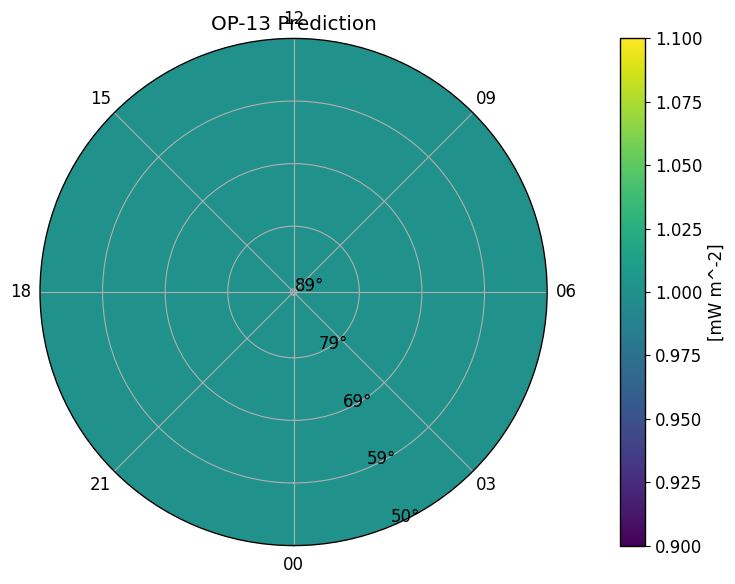

In [40]:
# Reshape into a grid (MLT=rows, ML=columns)
grid = df_eflux.pivot(index='MLT', columns='ML', values='A(x)')

# Convert MLT to radians
theta = np.deg2rad(grid.index * 15)  # 15° per hour

#Invert ML since the plot was backward
ml = grid.columns.values
ml_inverted = ml.max() - ml

# Extend edges for pcolormesh
theta_edges = np.append(theta, theta[0] + 2*np.pi)  # Close the loop (24h)
ml_edges = np.append(ml_inverted, ml_inverted[-1] + np.diff(ml_inverted)[0])  # Extend edges


# Plot
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': 'polar'})
pc = ax.pcolormesh(
    theta_edges,
    ml_edges,
    grid.T,  # Transpose to match (ML, MLT)
    cmap='viridis',
    shading='auto'
)

ax.set_theta_zero_location('S')  # 0° at bottom
ax.set_theta_direction(1)       # Set correct direction for MLT

# Label MLT ticks
ax.set_xticks(np.linspace(0, 2*np.pi, 8, endpoint=False))
ax.set_xticklabels(['00', '03', '06', '09', '12', '15', '18', '21'])

# Label ML ticks
r_ticks = np.linspace(ml.min(), ml.max(), 5)
ax.set_yticks(ml.max() - r_ticks)
ax.set_yticklabels([f'{int(x)}°' for x in r_ticks])

# Add labels and colorbar
#ax.set_xlabel('Magnetic Local Time (MLT)')
#ax.set_ylabel('Magnetic Latitude (ML)')
plt.colorbar(pc, label='[mW m^-2]', pad=0.1)
plt.title('OP-13 Prediction')
plt.tight_layout()
plt.show()